For this chapter I will use functions from chapter 1 of the book that are implemented in different libraries, because I have already implemented them myself (see chapter1 directory) and functiom from the libraries are for sure more efficient.

### Task 1
Use the rate given by equation 2.1 with $r_0$ = 50 Hz and 
$$
D(\tau) = -cos\left(\frac{2\pi(\tau - 20 \ ms)}{140 \ ms}\right)exp\left(-\frac{\tau}{60 \ ms}\right) Hz/ms
$$
<br>

to predict the response of a neuron of the electrosensory lateral-line lobe to a stimulus. The above equation is an approximation for the linear kernel obtained from the spike-triggered average shown in figure 1.9. Use an approximate Gaussian white-noise stimulus to constructed by choosing a stimulus value every 10 ms ($\Delta t$ = 10 ms) from a Gaussian distribution with zero mean and variance $\sigma_{s}^2 / \Delta t$ with $\sigma_{s}^2 = 10$. Compute the firing rate over a 10 s period. From the results, compute the firing rate-stimulus correlation $Q_{rs}(\tau)$.  Using equation 2.6, compare $Q_{rs}(-\tau)/\sigma_s^{2}$ with the kernel $D(\tau)$ fiven above.

We will do everything with respect to seconds, therefore, we have to convert $Hz/ms$ to $Hz/s = Hz/(ms \cdot 10^{-3})$ => $D(\tau) := 1000 \cdot D(\tau)$. <br>
Also all constants in the equation with ms (milliseconds) will be converted to s (seconds).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from spike_generator import *
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.linewidth'] = 0.8

Define Wiener kernel and white noise stimulus

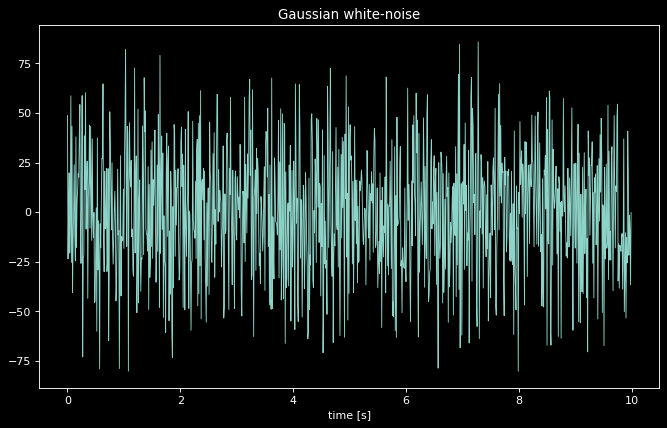

In [2]:
def D(τ):
    return -1000*np.cos(2*np.pi*(τ - 0.02)/0.14)*np.exp(-τ/0.06)
    
time = 10 
Δt = 0.01
σ = np.sqrt(10)
var = σ**2 / Δt

time_vec = np.arange(0, 10, Δt)
wn_stim = np.random.normal(loc=0, scale=np.sqrt(var), size=int(time/Δt))
plt.plot(time_vec, wn_stim);
plt.xlabel('time [s]')
plt.title('Gaussian white-noise');

Now we calculate the firing rate given the equation:
$$
r(t) = 50 + \int_0^{300 \ ms}{d\tau D(\tau)s(t - \tau)}
$$

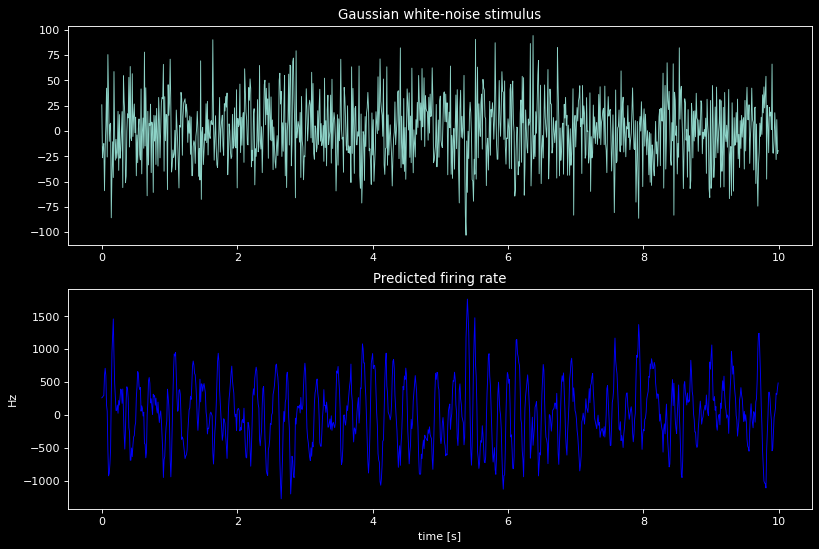

In [5]:
τ = np.arange(0, 0.6, Δt)
K = D(τ)

r = 50 + np.convolve(K, np.concatenate((wn_stim[-K.size+1:], wn_stim)), mode='valid') * Δt
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(time_vec, wn_stim)
axs[0].set_title('Gaussian white-noise stimulus');
axs[1].plot(time_vec, r, 'b')
axs[1].set(xlabel='time [s]', ylabel='Hz');
axs[1].set_title('Predicted firing rate');

Calculate response-stimulus crosscorrelation:
    $$
    Q_{rs}(\tau) = \frac{1}{10 \ s} \int_{0}^{10 \ s}{dt \ r(t) s(t + \tau)}
    $$
<br>
I interchange terms in the code below for the np.correlate function, becuase in the docs one can see:
$$
C_{av}[k] = \sum_{0}^n{a[n+k] \cdot v[n]}
$$

In [ ]:
Q_rs = np.correlate(np.concatenate((wn_stim, wn_stim)), r, mode='valid') # concatenation for making signal cyclic
Q_rs = Q_rs / r.size
plt.plot(np.linspace(0, time, Q_rs.size), Q_rs);
plt.xlabel('τ [s]');
plt.ylabel('$Q_{rs}(τ)$', labelpad=15).set_rotation(0);
plt.title('Stimulus-response crosscorrelation');

Compare kernels from two different formulas:

$$
Q_{rs}(-\tau) = \frac{1}{10 \ s} \int_0^{10 \ s}{dt \ r(t) s(t - \tau)}  = \frac{1}{10 \ s} \int_0^{10 \ s}{dt \ s(t) r(t + \tau)}
$$

In [ ]:
Q_rs = np.correlate(np.concatenate((r, r)), wn_stim, mode='valid') / r.size
D1 = D(τ)
D2 = Q_rs[0:τ.size] / σ**2
plt.plot(-τ, D1);
plt.plot(-τ, D2);
plt.xlabel('τ [ms]');
plt.ylabel('Hz/s', labelpad=15, fontsize=15).set_rotation(0)

### Task 2
MATLAB file c1p8.mat contains the data described in exercise 8 of chapter 1. Use the spike-triggered average (calculated in that exercise) to construct a linear kernel and use it in equation 2.1 to provide a model of the response of the H1 neuron. Choose $r_0$ so that the average firing rate predicted by the model in response to the stimulus used for the data matches the actual average firing rate. Use a Poisson generator with the computed rate to generate a synthetic spike train from this linear estimate of the firing rate in response to the stimulus. Plot examples of the actual and synthetic spike trains. How are they similar and how do they differ? Plot the autocorrelation function of the actual and the synthetic spike trains over the range 0 to 100 ms. Why is there a dip at lag of 2 ms in the autocorrelation of the actual spike train? Is there a dip for the synthetic train too? Plot the interspike interval histogram for both spike trains. Why is there a dip below 6 ms in the histogram for the actual spike train? What are the coefficients of variation for the two spike trains and why might they differ?

**1) Load the data, create time vector**

In [3]:
data = loadmat('c1p8.mat')
spikes = data['rho']
stim = data['stim']

# Sampling frequency 500 Hz => 500 samples / s => 1s/500 - Δt between sampling
Δt = 1/500

# Duration of the experiment is 20 minutes = 20 * 60 seconds:
T = 20*60
time = np.arange(0, T, Δt)

**2) Calculate spike-trigerred average stimulus**

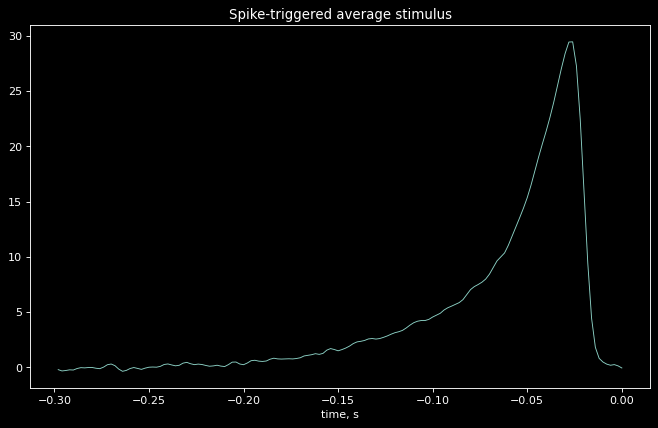

In [4]:
sta_stim, sta_time = STA_new(stim, time, spikes, window=300)
# time goes backwards with respect to reference point because "average stimulus before the spike"
sta_time = sta_time[::-1]
fig, ax = plt.subplots();
ax.plot(sta_time, sta_stim, label='stimulus');
ax.set_title('Spike-triggered average stimulus');
ax.set(xlabel='time, s');

**3) Calculate the kernel $D(\tau)$**

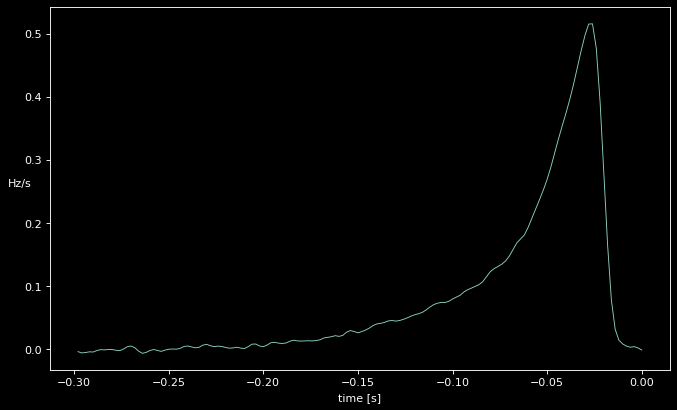

In [5]:
r_avg = np.sum(spikes)/T
σ = stim.std() 
K = r_avg * sta_stim/ σ**2
plt.figure()
plt.plot(sta_time, K);
plt.xlabel('time [s]');
plt.ylabel('Hz/s').set_rotation(0)

**4) Calculate firing rate $r(t)$**
$$
(a * v)[n] = \sum_{m = -\infty}^{\infty} a[m] v[n - m]
$$

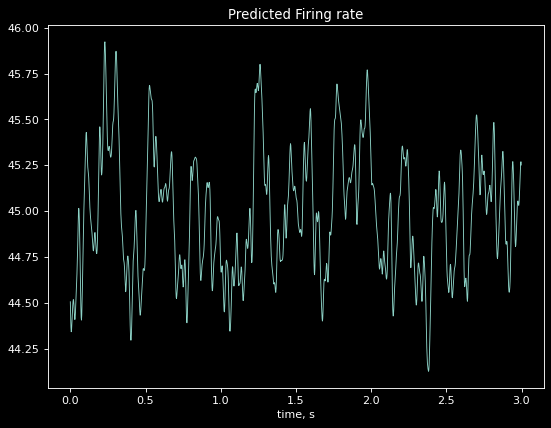

In [6]:
stim, K = stim.flatten(), K.flatten()
r0 = 45
r = r0 + np.convolve(K, np.concatenate((stim[-K.size+1:], stim)), mode='valid') * Δt
fig, ax = plt.subplots(figsize=(8, 6));
ax.plot(time[0:1500], r[0:1500], label='stimulus');
ax.set_title('Predicted Firing rate');
ax.set(xlabel='time, s');

**5) Generate spike train using predicted firing rate**

In [7]:
synthetic_train, _ = NonhomogeneousPoissonVector(r, time, T)

In [8]:
spikes = spikes.flatten()
actual_train = np.where(spikes == 1)[0] * Δt

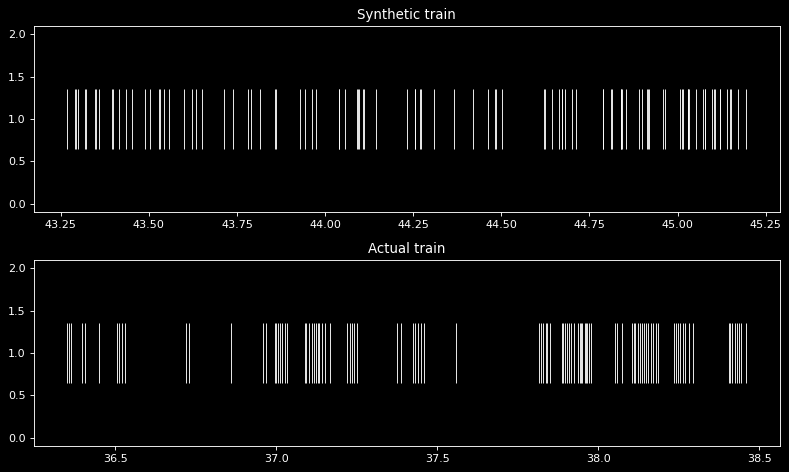

In [9]:
fig, axs = plt.subplots(2, 1)
axs[0].eventplot(synthetic_train[2000:2100], linelength=.7);
axs[0].set_title('Synthetic train')
axs[1].eventplot(actual_train[2000:2100], linelength=.7);
axs[1].set_title('Actual train')
fig.tight_layout()

**6) Autocorrelation of spike trains**

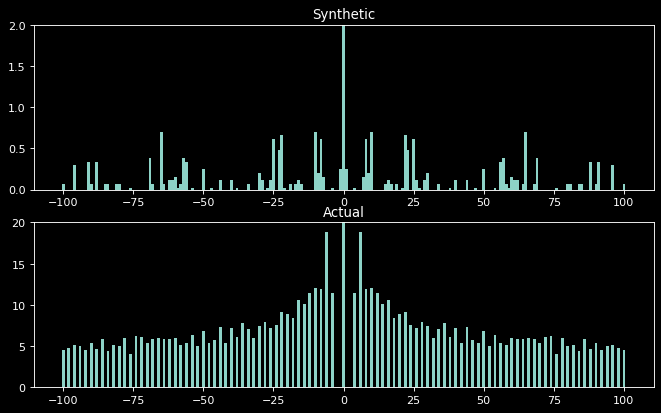

In [10]:
fig, axs = plt.subplots(2, 1)
locs1, freqs1 = autocorrelation(synthetic_train[:1000], time_lag=100, dt=1e-3)
locs2, freqs2 = autocorrelation(actual_train[:1000], time_lag=100, dt=1e-3)

axs[0].bar(locs1, freqs1, width=1, bottom=0)
axs[0].set_ylim(0,2)
axs[0].set_title('Synthetic');
axs[1].bar(locs2, freqs2, width=1, bottom=0)
axs[1].set_ylim(0,20)
axs[1].set_title('Actual');

**7) Interspike interval histograms**

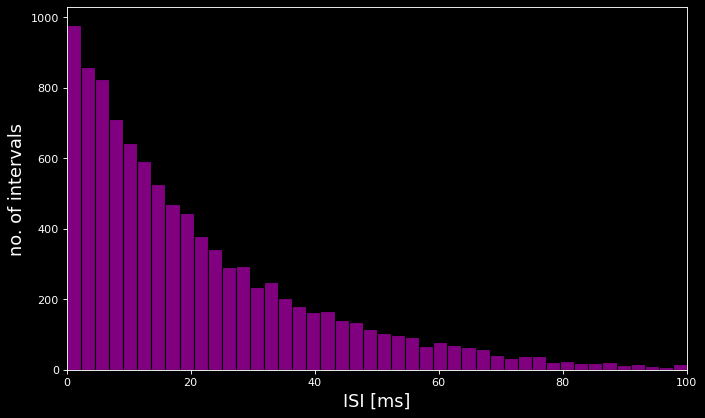

In [15]:
ISI_distribution( synthetic_train[0:10000] );
plt.xlim(0, 100);

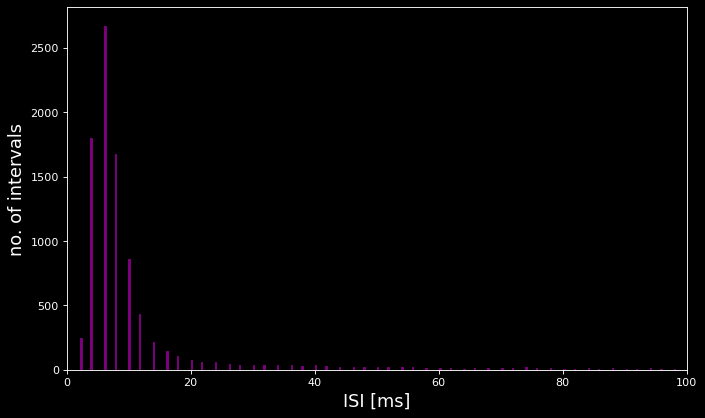

In [16]:
ISI_distribution( actual_train[0:10000] );
plt.xlim(0, 100);

**8) Coefficients of variation**

In [13]:
cv_syn = coefficient_variation(np.diff(synthetic_train))
cv_act = coefficient_variation(np.diff(actual_train))
print( "C_v of syn. train: %s" % cv_syn)
print( "C_v of act. train: %s" % cv_act)

C_v of syn. train: 0.9911354648503222
C_v of act. train: 2.0085523370640965


### Task 3
MATLAB file c2p3.mat contains the responses of a cat LGN cell to two-dimensional images (these data are described in Kara, P, Reinagel, P, & Reid, RC (2000) Low response variability in simultaneously recorded retinal, thalamic, and cortical neurons. *Neuron* **30**:803-817 and were kindly provided by Clay Reid). In the file, **counts** is a vector containing the number of spikes in each 15.6 ms bin, and **stim** contains the 32767, 16 by 16 images that were presented at the corresponding times. Specifically, stim(x, y, t) is the stimulus presented  at the coordinate (x,y) at time-step t. Note that stim is and int8 array that must to be converted into **double** using the command stim=double(stim) in order to be manipulated within MATLAB. Calculate the spike-triggered average images for each of the 12 time steps before each spike and show themm all (using imagesec command). Note that in this example, the time bins can have more than one spike, so the spike-triggered average must be computed by weighting each stimulus by the number of spikes in the corresponding time bin, rather than weighting it by either 1 or 0 depending on whether a spike is present or not. In the averaged images, you should see a central receptive field that reverses sign over time. By summing up the images acroos spatial dimension, produce a figure like that of figure 2.25C. (Based on a problem from Sebastian Seung.)

**1) Loading the data**

In [26]:
data2 = loadmat('c2p3.mat')
counts = data2['counts']
stim_imgs = data2['stim']
stim_imgs[stim_imgs == -1] = 0

(16, 16, 32767)
32767


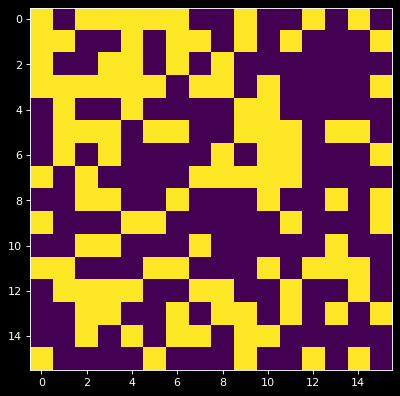

In [39]:
print(stim_imgs.shape)
print(len(counts))
plt.imshow(stim_imgs[:,:, 2]);

**2) Calculating spike-triggered averages for 12 time steps**

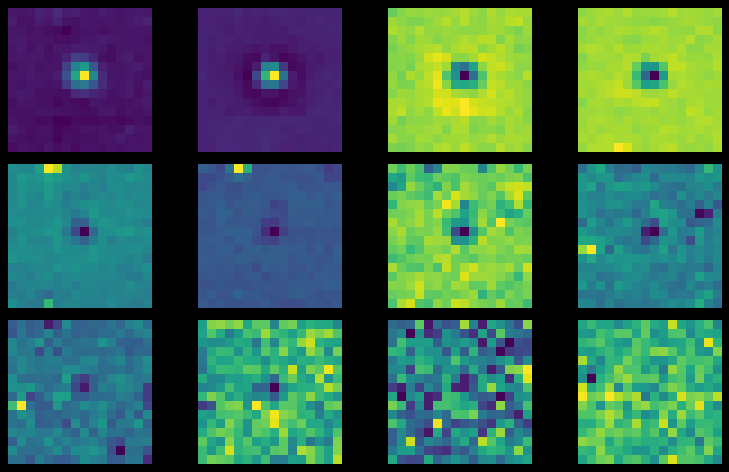

In [109]:
counts = counts.flatten()
sta_images = np.zeros((16, 16, 12))
spikes_idx = np.nonzero(counts)[0]

for j in range(12):
    sta_images[:, :, j] = (counts[spikes_idx] * stim_imgs[:, :, spikes_idx-j]).sum(axis=2)
    sta_images[:, :, j] /= counts.sum()

fig, axs = plt.subplots(3, 4);
for i in range(3):
    for j in range(4):
        axs[i,j].axis('off')

axs[0,0].imshow(sta_images[:, :, 0]);
axs[0,1].imshow(sta_images[:, :, 1]);
axs[0,2].imshow(sta_images[:, :, 2]);
axs[0,3].imshow(sta_images[:, :, 3]);

axs[1,0].imshow(sta_images[:, :, 4]);
axs[1,1].imshow(sta_images[:, :, 5]);
axs[1,2].imshow(sta_images[:, :, 6]);
axs[1,3].imshow(sta_images[:, :, 7]);

axs[2,0].imshow(sta_images[:, :, 8]);
axs[2,1].imshow(sta_images[:, :, 9]);
axs[2,2].imshow(sta_images[:, :, 10]);
axs[2,3].imshow(sta_images[:, :, 11]);
fig.tight_layout()

**3) Time course of X-axis** <br>
    - Sum over columns in (X, Y)

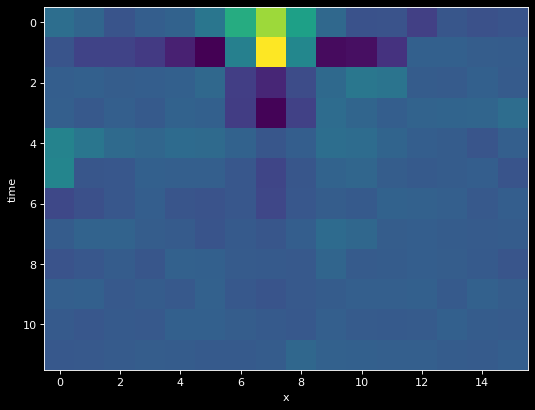

In [111]:
sta_xt = sta_images.sum(axis=1)
plt.imshow(sta_xt.T);
plt.xlabel('x');
plt.ylabel('time');